In [ ]:
import pandas as pd

# Load the CSV file to inspect the first few rows and understand its structure
data = pd.read_csv('/content/dataset_reducido.csv')
data.head()

,FECHACORTE,FECHAREGISTRO,CODIGO,NOMBRE,CATEGORIA,NIVEL,INSTITUCIÓN,GRUPO,SUB_GRUPO,MACROREGIONES,...,ZNC_VENT_CAM_TOTAL,ZNC_VENT_CAM_INOPERATIVO,ZNC_VENT_CAM_OPERATIVO,ZNC_VENT_CAM_DISPONIBLE,ZNC_VENT_CAM_EN_USO,ZNC_MONT_CAM_TOTAL,ZNC_MONT_CAM_INOPERATIVO,ZNC_MONT_CAM_OPERATIVO,ZNC_MONT_CAM_DISPONIBLE,ZNC_MONT_CAM_EN_USO
0,20210331,2021/03/31 4:53:43 PM,11113.0,CLINICA MONTERRICO,II-E,Nivel 2,PRIVADO,PRIVADOS,PRIVADOS,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,20210331,2021/03/31 6:33:02 PM,9066.0,HOSPITAL HIGOS URCO,II-1,Nivel 2,ESSALUD,PÚBLICOS,ESSALUD,Zona Norte,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,20210331,2021/03/31 6:24:36 PM,10267.0,HOSPITAL I ESSALUD-SULLANA,I-4,Nivel 1,ESSALUD,PÚBLICOS,ESSALUD,Zona Norte,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0
3,20210331,2021/03/31 7:56:52 AM,16551.0,CLINICA BELEN S.A.C. (CLINICA JUAN PABLO II),II-1,Nivel 2,PRIVADO,PRIVADOS,PRIVADOS,Zona Centro,...,0.0,0.0,0.0,0.0,0.0,3.0,0.0,3.0,2.0,1.0
4,20210331,2021/03/31 9:42:12 PM,10987.0,INSTITUTO MEDICO ESPECIALIZADO UROGINEC EIRL (...,II-1,Nivel 2,PRIVADO,PRIVADOS,PRIVADOS,Zona Centro,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
data2 = pd.read_csv('/content/dataset_reducido2.csv')
data2.head()

,FECHA_CORTE,DEPARTAMENTO,PROVINCIA,DISTRITO,METODODX,EDAD,SEXO,FECHA_RESULTADO,UBIGEO,id_persona
0,20241203,TUMBES,TUMBES,TUMBES,AG,46.0,FEMENINO,20221207.0,240101.0,203499.0
1,20241203,LIMA,LIMA,JESUS MARIA,AG,69.0,FEMENINO,20230822.0,150113.0,221397.0
2,20241203,SAN MARTIN,MOYOBAMBA,MOYOBAMBA,AG,55.0,FEMENINO,20240108.0,220101.0,295651.0
3,20241203,AREQUIPA,CAYLLOMA,COPORAQUE,AG,50.0,MASCULINO,20230824.0,40506.0,851625.0
4,20241203,LIMA,LIMA,JESUS MARIA,AG,58.0,MASCULINO,20221217.0,150113.0,287786.0


# dataset con informacion generada

In [ ]:
import numpy as np

# Number of patients
num_patients = 100

# Generate random data for patients
np.random.seed(42)  # For reproducibility
patients_data = {
    'patient_id': np.arange(num_patients),
    'severity': np.random.randint(1, 6, size=num_patients),  # Severity levels from 1 to 5
    'location_x': np.random.uniform(-90, 90, size=num_patients),  # Simulated latitude
    'location_y': np.random.uniform(-180, 180, size=num_patients)  # Simulated longitude
}

patients_df = pd.DataFrame(patients_data)

# Show the first few rows of patients data
patients_df.head()


,patient_id,severity,location_x,location_y
0,0,4,74.692742,63.248442
1,1,5,63.006944,84.677803
2,2,3,-9.098879,-104.734217
3,3,5,-72.826179,14.921271
4,4,5,-23.252715,70.482384


In [ ]:
# Filter necessary hospital columns and clean data
hospital_data = data[['CODIGO', 'NOMBRE', 'ZNC_MONT_CAM_DISPONIBLE']].copy()
hospital_data = hospital_data.dropna(subset=['CODIGO', 'ZNC_MONT_CAM_DISPONIBLE'])
hospital_data['CODIGO'] = hospital_data['CODIGO'].astype(int)  # Ensure that the code is an integer
hospital_data = hospital_data[hospital_data['ZNC_MONT_CAM_DISPONIBLE'] > 0]  # Only consider hospitals with available beds

# Show the prepared hospital data
hospital_data.head(), hospital_data.shape



(   CODIGO                                        NOMBRE  \
 2   10267                    HOSPITAL I ESSALUD-SULLANA   
 3   16551  CLINICA BELEN S.A.C. (CLINICA JUAN PABLO II)   
 6    7686           HOSPITAL REGIONAL DOCENTE CAJAMARCA   
 7   15927                     CLINICA DE OJOS D´OPELUCE   
 8    1232                            HOSPITAL GOYENECHE   
 
    ZNC_MONT_CAM_DISPONIBLE  
 2                      1.0  
 3                      2.0  
 6                      5.0  
 7                      1.0  
 8                      2.0  ,
 (407, 3))

In [ ]:
!pip install ortools

In [ ]:
from ortools.sat.python import cp_model

# Modelo
model = cp_model.CpModel()

# Variables
x = {}  # x[(i, k)] = 1 if patient k is assigned to a bed in hospital i
for index, hospital in hospital_data.iterrows():
    for k in patients_df['patient_id']:
        x[(hospital['CODIGO'], k)] = model.NewBoolVar(f'x[{hospital["CODIGO"]},{k}]')

# Restricciones
# Cada paciente es asignado a lo más a un hospital
for k in patients_df['patient_id']:
    model.Add(sum(x[(i, k)] for i in hospital_data['CODIGO']) <= 1)

# Cada hospital no excede su capacidad de camas
for index, hospital in hospital_data.iterrows():
    # Aseguramos que la capacidad es un entero
    cap = int(hospital['ZNC_MONT_CAM_DISPONIBLE'])
    model.Add(sum(x[(hospital['CODIGO'], k)] for k in patients_df['patient_id']) <= cap)

# Objetivo: Maximizar el número de pacientes asignados a camas, ponderado por la gravedad
model.Maximize(sum(x[(i, k)] * patients_df.loc[patients_df['patient_id'] == k, 'severity'].iloc[0]
                   for i in hospital_data['CODIGO'] for k in patients_df['patient_id']))

# Resolver el modelo
solver = cp_model.CpSolver()
status = solver.Solve(model)

# Verificar el estado de la solución y mostrar las asignaciones
if status == cp_model.OPTIMAL or status == cp_model.FEASIBLE:
    print("Pacientes asignados a hospitales:")
    for index, hospital in hospital_data.iterrows():
        for k in patients_df['patient_id']:
            if solver.Value(x[(hospital['CODIGO'], k)]) == 1:
                print(f'Hospital: {hospital["NOMBRE"]}, Paciente ID: {k}, Severidad: {patients_df.loc[k, "severity"]}')
else:
    print("No se encontró solución.")

Pacientes asignados a hospitales:
Hospital: CLINICA EL GOLF, Paciente ID: 6, Severidad: 3
Hospital: CLINICA EL GOLF, Paciente ID: 56, Severidad: 4
Hospital: CENTRO MEDICO RIOJA - ESSALUD, Paciente ID: 5, Severidad: 2
Hospital: CENTRO DE SALUD CON INTERNAMIENTO MOCHE, Paciente ID: 23, Severidad: 1
Hospital: HOSPITAL REGIONAL DOCENTE DE MEDICINA TROPICAL DR. JULIO CESAR DEMARINI CARO, Paciente ID: 1, Severidad: 5
Hospital: HOSPITAL REGIONAL DOCENTE LAS MERCEDES, Paciente ID: 7, Severidad: 3
Hospital: CENTRO MEDICO ESPECIALIZADO VERONESI SAC, Paciente ID: 8, Severidad: 3
Hospital: HOSPITAL LA CALETA, Paciente ID: 20, Severidad: 2
Hospital: HOSPITAL LA CALETA, Paciente ID: 21, Severidad: 5
Hospital: HOSPITAL LA CALETA, Paciente ID: 25, Severidad: 3
Hospital: HOSPITAL LA CALETA, Paciente ID: 27, Severidad: 2
Hospital: HOSPITAL LA CALETA, Paciente ID: 29, Severidad: 4
Hospital: HOSPITAL LA CALETA, Paciente ID: 32, Severidad: 4
Hospital: HOSPITAL LA CALETA, Paciente ID: 40, Severidad: 4
Hospi

# Combinar datasets

In [ ]:
# Imprimir los nombres de las columnas de ambos datasets
print("Columnas en dataset reducido1:", data.columns.tolist())
print("Columnas en dataset reducido2:", data2.columns.tolist())


Columnas en dataset reducido1: ['FECHACORTE', 'FECHAREGISTRO', 'CODIGO', 'NOMBRE', 'CATEGORIA', 'NIVEL', 'INSTITUCIÓN', 'GRUPO', 'SUB_GRUPO', 'MACROREGIONES', 'UBIGEO', 'REGION', 'PROVINCIA', 'DISTRITO', 'RESPONSABLE', 'CUENTA_TRIAJE', 'NU_ATENC_ULT', 'CUENTA_ZC', 'ZC_UCI_AACT_CAM_TOTAL', 'ZC_UCI_AACT_CAM_INOPERATIVOS', 'ZC_UCI_AACT_CAM_TOT_OPER', 'ZC_UCI_AACT_CAM_TOT_DISP', 'ZC_UCI_AACT_CAM_TOT_OCUP', 'ZC_UCI_AACT_COC_CAM_CONFIR', 'ZC_UCI_AACT_COC_CAM_X_CONFIR', 'ZC_UCI_AACT_COO_CAM_CANULAS', 'ZC_UCI_AACT_COO_CAM_SIN_VM', 'ZC_UCI_AACT_COO_CAM_CON_VM', 'ZC_UCI_ADUL_CAM_TOTAL', 'ZC_UCI_ADUL_CAM_INOPERATIVOS', 'ZC_UCI_ADUL_CAM_TOT_OPER', 'ZC_UCI_ADUL_CAM_TOT_DISP', 'ZC_UCI_ADUL_CAM_TOT_OCUP', 'ZC_UCI_ADUL_COC_CAM_CONFIR', 'ZC_UCI_ADUL_COC_CAM_X_CONFIR', 'ZC_UCI_ADUL_COO_CAM_CANULAS', 'ZC_UCI_ADUL_COO_CAM_SIN_VM', 'ZC_UCI_ADUL_COO_CAM_CON_VM', 'ZC_UCI_NEONATAL_CAM_TOTAL', 'ZC_UCI_NEONATAL_CAM_INOPERATIVOS', 'ZC_UCI_NEONATAL_CAM_TOT_OPER', 'ZC_UCI_NEONATAL_CAM_TOT_DISP', 'ZC_UCI_NEONATAL_C

In [ ]:
# Normalización de datos, si es necesario (ejemplo con datos ficticios)
data['PROVINCIA'] = data['PROVINCIA'].str.upper().str.strip()
data['DISTRITO'] = data['DISTRITO'].str.upper().str.strip()
data2['PROVINCIA'] = data2['PROVINCIA'].str.upper().str.strip()
data2['DISTRITO'] = data2['DISTRITO'].str.upper().str.strip()

# Combinar los datasets basado en 'PROVINCIA' y 'DISTRITO'
combined_data = pd.merge(data, data2, on=['PROVINCIA', 'DISTRITO'], how='left')

# Visualizar las primeras filas del dataset combinado para verificar
print(combined_data.head())


   FECHACORTE           FECHAREGISTRO   CODIGO              NOMBRE CATEGORIA  \
0    20210331  2021/03/31  4:53:43 PM  11113.0  CLINICA MONTERRICO      II-E   
1    20210331  2021/03/31  4:53:43 PM  11113.0  CLINICA MONTERRICO      II-E   
2    20210331  2021/03/31  4:53:43 PM  11113.0  CLINICA MONTERRICO      II-E   
3    20210331  2021/03/31  4:53:43 PM  11113.0  CLINICA MONTERRICO      II-E   
4    20210331  2021/03/31  4:53:43 PM  11113.0  CLINICA MONTERRICO      II-E   

     NIVEL INSTITUCIÓN     GRUPO SUB_GRUPO MACROREGIONES  ...  \
0  Nivel 2     PRIVADO  PRIVADOS  PRIVADOS           NaN  ...   
1  Nivel 2     PRIVADO  PRIVADOS  PRIVADOS           NaN  ...   
2  Nivel 2     PRIVADO  PRIVADOS  PRIVADOS           NaN  ...   
3  Nivel 2     PRIVADO  PRIVADOS  PRIVADOS           NaN  ...   
4  Nivel 2     PRIVADO  PRIVADOS  PRIVADOS           NaN  ...   

   ZNC_MONT_CAM_DISPONIBLE ZNC_MONT_CAM_EN_USO FECHA_CORTE DEPARTAMENTO  \
0                      0.0                 0.0  20241

In [ ]:
import pandas as pd

# Análisis del número total de pacientes por hospital
pacientes_por_hospital = combined_data.groupby('NOMBRE')['id_persona'].count()
print("Número de pacientes por hospital:\n", pacientes_por_hospital)

# Análisis de la capacidad hospitalaria vs. demanda
capacidad_vs_demanda = combined_data.groupby('NOMBRE').agg({
    'id_persona': 'count',
    'ZNC_MONT_CAM_DISPONIBLE': 'mean'  # Asumiendo que este dato no cambia por fila para el mismo hospital
})
capacidad_vs_demanda['sobre_capacidad'] = capacidad_vs_demanda['id_persona'] > capacidad_vs_demanda['ZNC_MONT_CAM_DISPONIBLE']
print("Capacidad vs. Demanda por hospital:\n", capacidad_vs_demanda)

Número de pacientes por hospital:
 NOMBRE
ADMINISTRADORA CLINICA TRESA            0
ADOLFO GUEVARA VELASCO                  4
AGUAYTIA                                0
ALBERTO LEONARDO BARTON THOMPSON       14
ANTONIO BARRIONUEVO (LAMPA)             0
                                       ..
VICTOR LAZARTE ECHEGARAY                4
VIRGEN DEL ROSARIO SA                   0
VIRGEN GUADALUPE CUSCO                  0
YUNGUYO                                 4
clinica especializada amazonica sac    12
Name: id_persona, Length: 497, dtype: int64
Capacidad vs. Demanda por hospital:
                                      id_persona  ZNC_MONT_CAM_DISPONIBLE  \
NOMBRE                                                                     
ADMINISTRADORA CLINICA TRESA                  0                      1.0   
ADOLFO GUEVARA VELASCO                        4                      0.0   
AGUAYTIA                                      0                      1.0   
ALBERTO LEONARDO BARTON THOMPSON   

In [ ]:
# Análisis de edad promedio y distribución de sexo por hospital
edad_sexo_por_hospital = combined_data.groupby('NOMBRE').agg({
    'EDAD': 'mean',
    'SEXO': pd.Series.mode  # Moda del sexo para ver cuál es más frecuente en cada hospital
})
print("Edad promedio y distribución de sexo por hospital:\n", edad_sexo_por_hospital)


Edad promedio y distribución de sexo por hospital:
                                           EDAD                   SEXO
NOMBRE                                                               
ADMINISTRADORA CLINICA TRESA               NaN                     []
ADOLFO GUEVARA VELASCO               47.000000  [FEMENINO, MASCULINO]
AGUAYTIA                                   NaN                     []
ALBERTO LEONARDO BARTON THOMPSON     60.285714              MASCULINO
ANTONIO BARRIONUEVO (LAMPA)                NaN                     []
...                                        ...                    ...
VICTOR LAZARTE ECHEGARAY             32.500000  [FEMENINO, MASCULINO]
VIRGEN DEL ROSARIO SA                      NaN                     []
VIRGEN GUADALUPE CUSCO                     NaN                     []
YUNGUYO                              71.500000              MASCULINO
clinica especializada amazonica sac  66.166667               FEMENINO

[497 rows x 2 columns]


<ipython-input-11-b4c4823171f3>:10: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


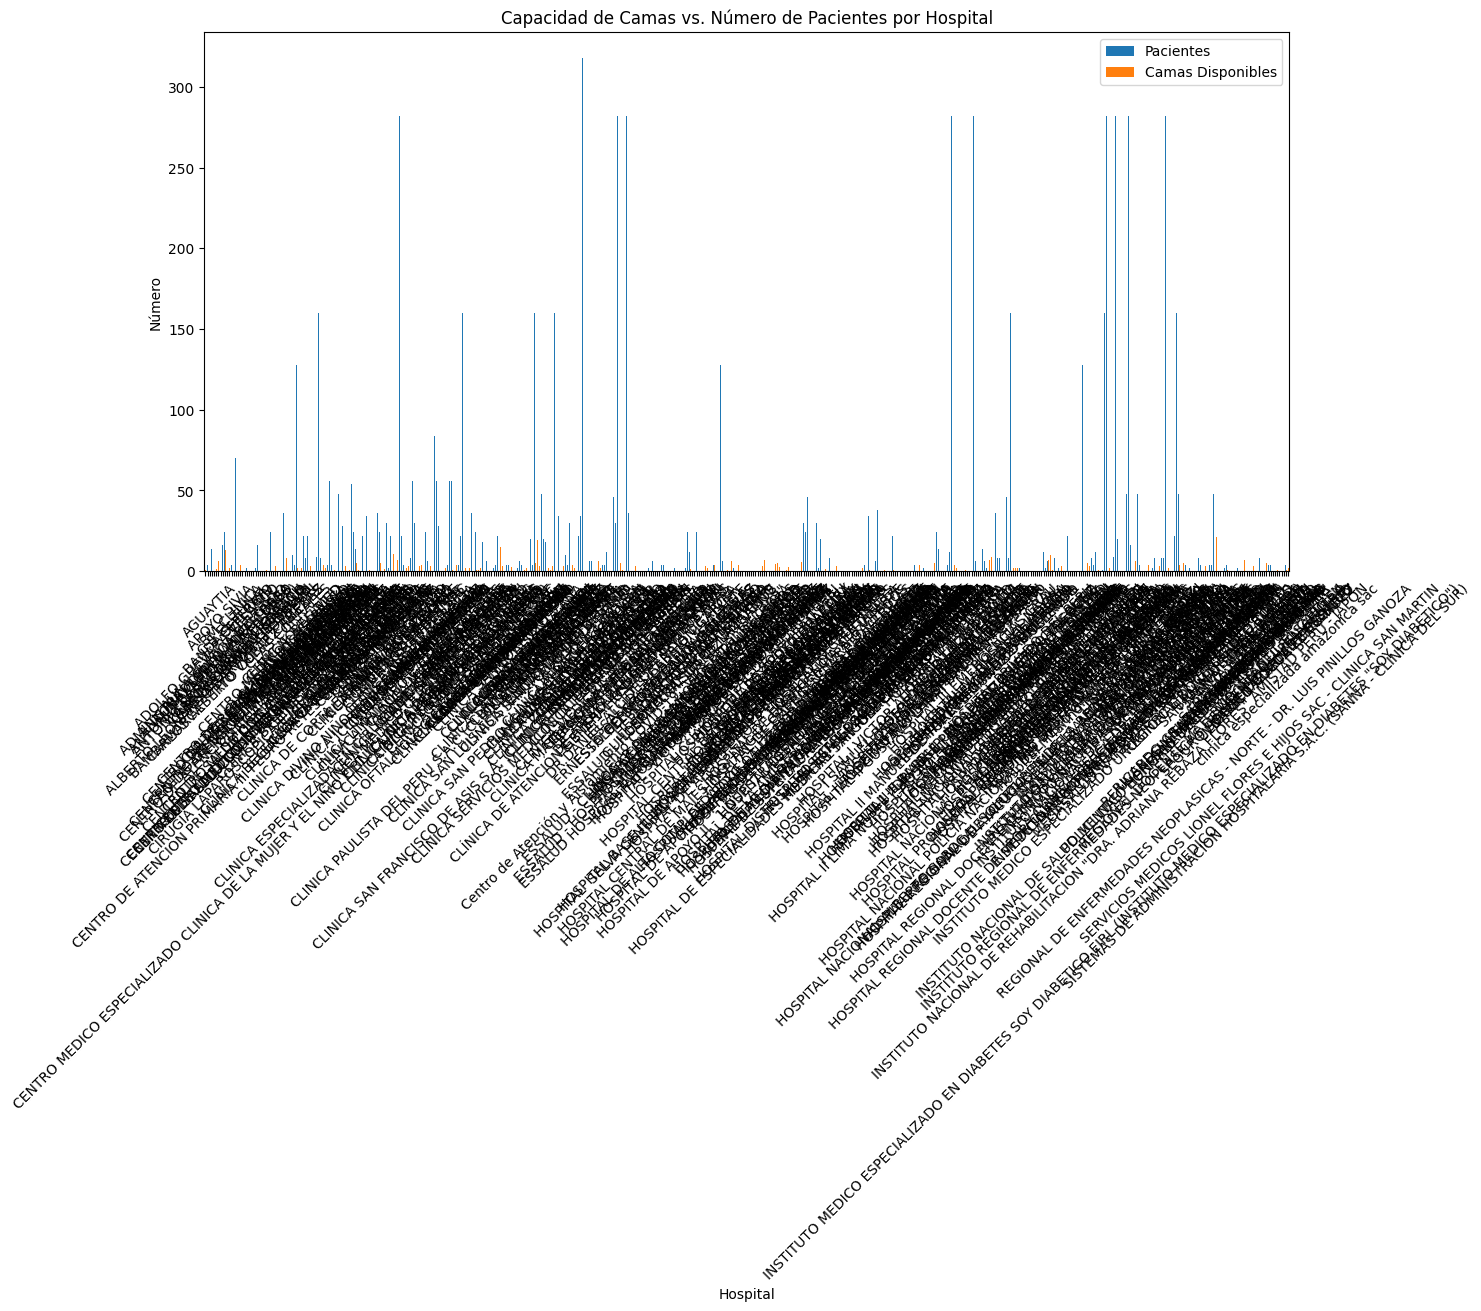

In [ ]:
import matplotlib.pyplot as plt

# Crear gráfico de barras para comparar capacidad de camas y número de pacientes
capacidad_vs_demanda.plot(kind='bar', y=['id_persona', 'ZNC_MONT_CAM_DISPONIBLE'], figsize=(14, 7))
plt.title('Capacidad de Camas vs. Número de Pacientes por Hospital')
plt.xlabel('Hospital')
plt.ylabel('Número')
plt.legend(['Pacientes', 'Camas Disponibles'])
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


<ipython-input-12-7a88d6215601>:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  combined_data['FECHAREGISTRO'] = pd.to_datetime(combined_data['FECHAREGISTRO'])


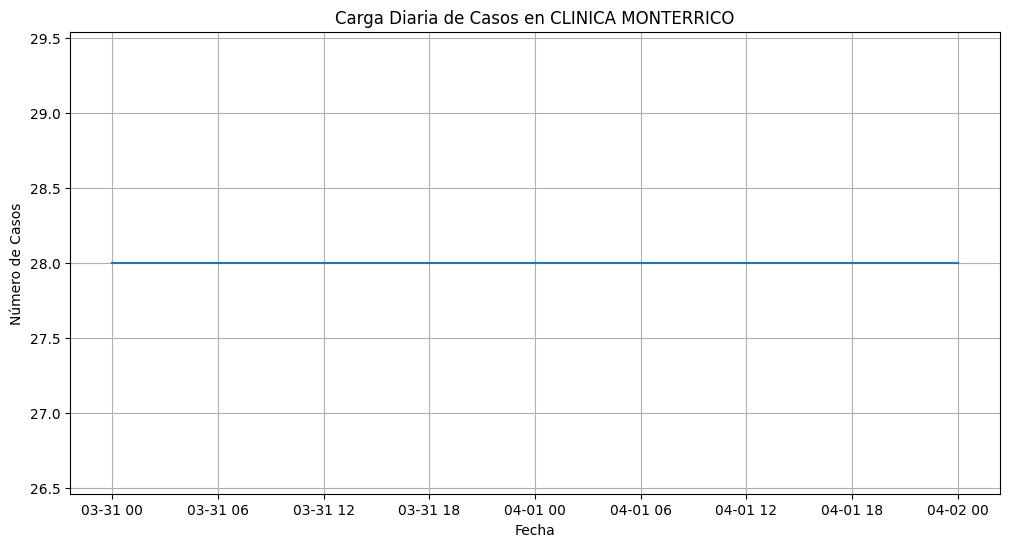

In [ ]:
# Convertir FECHAREGISTRO a datetime
combined_data['FECHAREGISTRO'] = pd.to_datetime(combined_data['FECHAREGISTRO'])

# Filtrar datos por un hospital específico, por ejemplo, 'CLINICA MONTERRICO'
clinica_data = combined_data[combined_data['NOMBRE'] == 'CLINICA MONTERRICO']

# Contar pacientes por fecha
pacientes_por_fecha = clinica_data.groupby(clinica_data['FECHAREGISTRO'].dt.date).size()

# Gráfico de la carga de casos a lo largo del tiempo
pacientes_por_fecha.plot(kind='line', figsize=(12, 6))
plt.title('Carga Diaria de Casos en CLINICA MONTERRICO')
plt.xlabel('Fecha')
plt.ylabel('Número de Casos')
plt.grid(True)
plt.show()


In [ ]:
import pandas as pd



dataset1 = pd.read_csv('/content/dataset_reducido.csv')
dataset2 = pd.read_csv('/content/dataset_reducido2.csv')

dataset1.head(), dataset2.head(), dataset1.columns, dataset2.columns


(   FECHACORTE           FECHAREGISTRO   CODIGO  \
 0    20210331  2021/03/31  4:53:43 PM  11113.0   
 1    20210331  2021/03/31  6:33:02 PM   9066.0   
 2    20210331  2021/03/31  6:24:36 PM  10267.0   
 3    20210331  2021/03/31  7:56:52 AM  16551.0   
 4    20210331  2021/03/31  9:42:12 PM  10987.0   
 
                                               NOMBRE CATEGORIA    NIVEL  \
 0                                 CLINICA MONTERRICO      II-E  Nivel 2   
 1                                HOSPITAL HIGOS URCO      II-1  Nivel 2   
 2                         HOSPITAL I ESSALUD-SULLANA       I-4  Nivel 1   
 3       CLINICA BELEN S.A.C. (CLINICA JUAN PABLO II)      II-1  Nivel 2   
 4  INSTITUTO MEDICO ESPECIALIZADO UROGINEC EIRL (...      II-1  Nivel 2   
 
   INSTITUCIÓN     GRUPO SUB_GRUPO MACROREGIONES  ...  ZNC_VENT_CAM_TOTAL  \
 0     PRIVADO  PRIVADOS  PRIVADOS           NaN  ...                 0.0   
 1     ESSALUD  PÚBLICOS   ESSALUD    Zona Norte  ...                 0.0   
 2 

In [ ]:
missing_values_dataset1 = dataset1.isnull().sum()
missing_values_dataset2 = dataset2.isnull().sum()
data_types_dataset1 = dataset1.dtypes
data_types_dataset2 = dataset2.dtypes

missing_values_dataset1, missing_values_dataset2, data_types_dataset1, data_types_dataset2


(FECHACORTE                  0
 FECHAREGISTRO               0
 CODIGO                      0
 NOMBRE                      0
 CATEGORIA                   0
                            ..
 ZNC_MONT_CAM_TOTAL          0
 ZNC_MONT_CAM_INOPERATIVO    0
 ZNC_MONT_CAM_OPERATIVO      0
 ZNC_MONT_CAM_DISPONIBLE     0
 ZNC_MONT_CAM_EN_USO         0
 Length: 206, dtype: int64,
 FECHA_CORTE          0
 DEPARTAMENTO         0
 PROVINCIA            0
 DISTRITO             0
 METODODX             0
 EDAD                 0
 SEXO                 0
 FECHA_RESULTADO      2
 UBIGEO             109
 id_persona           0
 dtype: int64,
 FECHACORTE                    int64
 FECHAREGISTRO                object
 CODIGO                      float64
 NOMBRE                       object
 CATEGORIA                    object
                              ...   
 ZNC_MONT_CAM_TOTAL          float64
 ZNC_MONT_CAM_INOPERATIVO    float64
 ZNC_MONT_CAM_OPERATIVO      float64
 ZNC_MONT_CAM_DISPONIBLE     float64
 ZNC_M

In [ ]:
# Simplifying Dataset 1 - Select relevant columns (assuming 'NOMBRE' for hospital name, and 'ZNC_MONT_CAM_TOTAL' for total beds)
simplified_dataset1 = dataset1[['NOMBRE', 'ZNC_MONT_CAM_TOTAL']].copy()

# Handle missing data in Dataset 2
# Drop rows where 'UBIGEO' is missing
simplified_dataset2 = dataset2.dropna(subset=['UBIGEO']).copy()

# Converting 'UBIGEO' and 'id_persona' to integers
simplified_dataset2['UBIGEO'] = simplified_dataset2['UBIGEO'].astype(int)
simplified_dataset2['id_persona'] = simplified_dataset2['id_persona'].astype(int)

# Review changes and display the first few rows of the simplified datasets
simplified_dataset1.head(), simplified_dataset2.head(), simplified_dataset1.dtypes, simplified_dataset2.dtypes


(                                              NOMBRE  ZNC_MONT_CAM_TOTAL
 0                                 CLINICA MONTERRICO                 0.0
 1                                HOSPITAL HIGOS URCO                 0.0
 2                         HOSPITAL I ESSALUD-SULLANA                 1.0
 3       CLINICA BELEN S.A.C. (CLINICA JUAN PABLO II)                 3.0
 4  INSTITUTO MEDICO ESPECIALIZADO UROGINEC EIRL (...                 0.0,
    FECHA_CORTE DEPARTAMENTO  PROVINCIA     DISTRITO METODODX  EDAD       SEXO  \
 0     20241203       TUMBES     TUMBES       TUMBES       AG  46.0   FEMENINO   
 1     20241203         LIMA       LIMA  JESUS MARIA       AG  69.0   FEMENINO   
 2     20241203   SAN MARTIN  MOYOBAMBA    MOYOBAMBA       AG  55.0   FEMENINO   
 3     20241203     AREQUIPA   CAYLLOMA    COPORAQUE       AG  50.0  MASCULINO   
 4     20241203         LIMA       LIMA  JESUS MARIA       AG  58.0  MASCULINO   
 
    FECHA_RESULTADO  UBIGEO  id_persona  
 0       20221207.0

In [ ]:
print(simplified_dataset2.columns)


Index(['FECHA_CORTE', 'DEPARTAMENTO', 'PROVINCIA', 'DISTRITO', 'METODODX',
       'EDAD', 'SEXO', 'FECHA_RESULTADO', 'UBIGEO', 'id_persona'],
      dtype='object')


In [ ]:
from ortools.sat.python import cp_model

# Modelo
model = cp_model.CpModel()

# Convertir DataFrame a diccionario para un acceso más rápido
hospital_beds = {(i, j): int(hospital['ZNC_MONT_CAM_TOTAL'])
                 for i, hospital in simplified_dataset1.iterrows()
                 for j in range(int(hospital['ZNC_MONT_CAM_TOTAL']))}

# Variables
x = {}  # x[(i, j, k)] = 1 si el paciente k está asignado a la cama j en el hospital i
for (i, j), beds in hospital_beds.items():
    for k in simplified_dataset2.index:
        x[(i, j, k)] = model.NewBoolVar(f'x[{i},{j},{k}]')

# Restricciones
# 1. Cada paciente es asignado a lo más a una cama en un hospital
for k in simplified_dataset2.index:
    model.Add(sum(x[(i, j, k)] for (i, j) in hospital_beds) <= 1)

# 2. Cada cama en un hospital es asignada a lo más a un paciente
for (i, j) in hospital_beds:
    model.Add(sum(x[(i, j, k)] for k in simplified_dataset2.index) <= 1)

# Objetivo: Maximizar el número de pacientes asignados a camas
model.Maximize(sum(x[(i, j, k)]
                   for (i, j) in hospital_beds for k in simplified_dataset2.index))

# Resolver el modelo
solver = cp_model.CpSolver()
solver.parameters.max_time_in_seconds = 300  # Límite de tiempo de 5 minutos
solver.parameters.log_search_progress = True  # Activar log de progreso

status = solver.Solve(model)

if status == cp_model.OPTIMAL:
    print("Solución óptima encontrada.")
elif status == cp_model.FEASIBLE:
    print("Se encontró una solución factible.")
else:
    print("No se pudo encontrar una solución óptima o factible en el tiempo dado.")
# Verificar el estado de la solución y mostrar las asignaciones
if status == cp_model.OPTIMAL or status == cp_model.FEASIBLE:
    print("Pacientes asignados a hospitales:")
    for (i, j) in hospital_beds:
        for k in simplified_dataset2.index:
            if solver.Value(x[(i, j, k)]) == 1:
                print(f'Hospital: {simplified_dataset1.loc[i, "NOMBRE"]}, Cama: {j}, Paciente ID: {k}')
else:
    print("No se encontró solución.")


No se pudo encontrar una solución óptima o factible en el tiempo dado.
No se encontró solución.


In [ ]:
print(f"Estado del solver: {solver.StatusName(status)}")
print(f"Se realizaron {solver.NumConflicts()} conflictos.")
print(f"Se realizaron {solver.NumBranches()} ramificaciones.")


Estado del solver: UNKNOWN
Se realizaron 0 conflictos.
Se realizaron 0 ramificaciones.
